In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.interpolate import splev, splrep
from scipy.optimize import fmin

# Interest Rate Models

The purpose of this project is to explore 2 Interest Rate Models and compare them.

## Vasicek (1977) Interest Rate Model

The Vasicek Interest Rate Model is a model that predicts where interest rates will move in the future. It uses the following process to determine interest rates $r_t$:

$$
\
\begin{equation*}
  dr_t = k(\theta-r_t)dt + \sigma dz_t
\end{equation*}
$$

Where the parameters are given by:

*   $\theta$ = long-term mean of interest rates
*   $k$ = speed of reversion (how quickly rates return) to mean $\theta$
*   $\sigma$ = instantaneous volatility at time t
*   $dz_t = \sqrt{dt} z$, with $z \sim \mathcal{N}(0,1)$.

## Cox-Ingersoll-Ross (CIR) (1985) Interest Rate Model

The CIR Interest rate model is an extension of the Vasicek model where the standard deviation of short term interest rate changes is made proportional to $\sqrt{r_t}$. This means that when the short rate gets higher, the standard deviation also increases, unlike the vasicek model.

The equation for the CIR model is the same as the Vasicek model with the addition of this term:

$$
\
\
\begin{equation*}
  dr_t = k(\theta-r_t)dt + \sigma \sqrt{r_t} dz_t
\end{equation*}
$$

## Simulated Monte Carlo Paths by Vasicek & CIR

Using the equations above, we can write functions for the Vasicek and CIR Interest rate models and simulate the evolution of short term interest rates.

In [18]:
def vasicek(r0, k, theta, sigma, T, steps):
    dt = T / steps
    path = np.zeros((steps, 1))
    path[0] = r0
    for i in range(1, steps):
        dr = (k * (theta - path[i - 1]) * dt + sigma * np.sqrt(dt) * np.random.normal())
        path[i] = path[i - 1] + dr
    return path

def cir(r0, k, theta, sigma, T, steps):
    dt = T / steps
    path = np.zeros((steps, 1))
    path[0] = r0
    for i in range(1, steps):
        dr = (k * (theta - path[i - 1]) * dt + sigma*np.sqrt(dt)*np.sqrt(np.maximum(path[i - 1], 0))*np.random.normal())
        path[i] = path[i - 1] + dr
    return path

We will use arbitrary starting parameters of $r_0$ = 0.05, $\theta$ = 0.025, $k$ = 0.20 and $\sigma$ = 0.01. Additionally, we will use 100 monte partlo simulations for each model, for 1 year and 365 time steps.

In [ ]:
M = 100  # Number of path simulations
T = 1  # Ending of modelling time at 1 year
steps = 365  # 365 steps for 365 days in the year

r0 = 0.05
k = 0.20
theta = 0.025
sigma = 0.01

In [ ]:
df_vasicek = pd.DataFrame()
df_cir = pd.DataFrame()
for i in range(M):
  df_vasicek[[i]] = vasicek(r0, k, theta, sigma, T, steps).tolist()
  df_cir[[i]] = cir(r0, k, theta, sigma, T, steps).tolist()

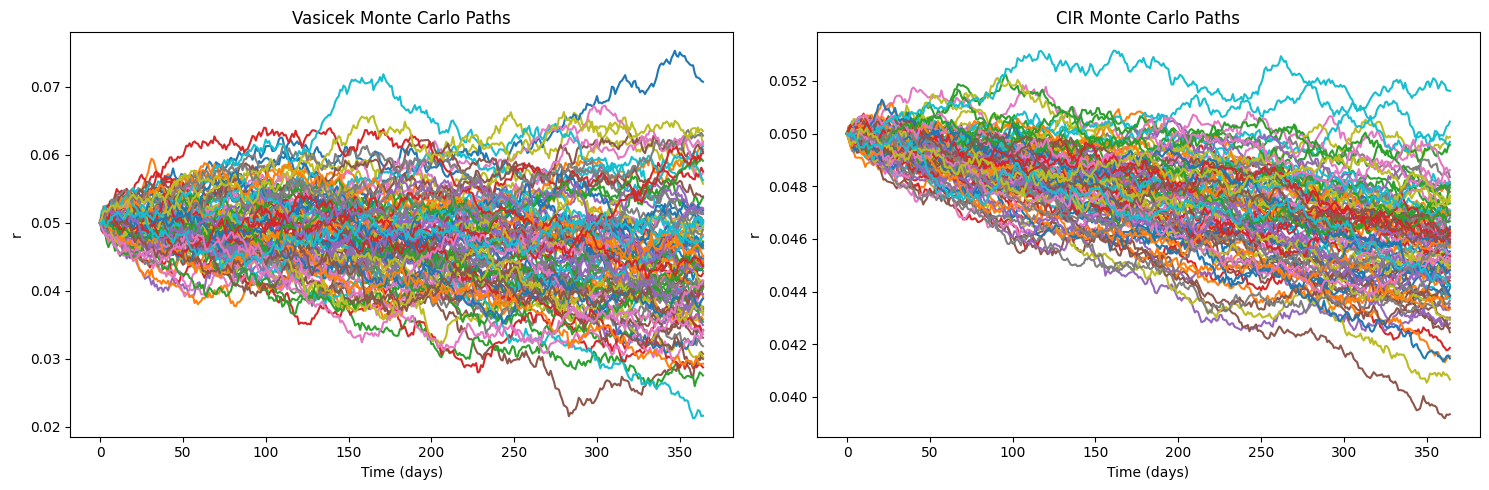

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df_vasicek)
plt.title('Vasicek Monte Carlo Paths')
plt.xlabel('Time (days)')
plt.ylabel('r')

plt.subplot(1, 2, 2)
plt.plot(df_cir)
plt.title('CIR Monte Carlo Paths')
plt.xlabel('Time (days)')
plt.ylabel('r')

plt.tight_layout()
plt.show()

In [ ]:
print('The mean interest rate at the end of one year using Vasicek simulations is ' + str(np.mean(df_vasicek.iloc[[-1]])) + '. With a standard deviation ' + str(df_vasicek.std(axis=1).iloc[-1]) + '.')
print('The mean interest rate at the end of one year using CIR simulations is ' + str(np.mean(df_cir.iloc[[-1]])) + '. With a standard deviation ' + str(df_cir.std(axis=1).iloc[-1]) + '.')

The mean interest rate at the end of one year using Vasicek simulations is 0.0447283367798385. With a standard deviation 0.009240314252534021.
The mean interest rate at the end of one year using CIR simulations is 0.045634574881023265. With a standard deviation 0.0020765477321584235.


As you can see in the time-series graphs above of the interest rate simulations, Vasicek and CIR do not have vastly different outcomes. The Vasicek model bears a mean ending interest rate of 0.0447 and the CIR model has a mean ending rate of 0.0456.

Although comparitivley, the Vasicek model has a standard deviation of final interest rates of 0.0092, which is much higher than CIR's final estimate standard deviation of 0.0021. This is inline with what we observe in the timeseries graphs, that the CIR paths have a much lower level of variation that the Vasicek ones.

This makes sense as the standard deviation term of the CIR equation $\sigma \sqrt{r_t}$ will always be less than the standard deviation term of the Vasicek mode, which is only $\sigma$.

## Calibrate CIR Model using current Canadian Rates

To calibrate a CIR model, we need to use Zero-Coupon Bond data since the CIR model happens in a risk-neutral setting.

We are going to use data for the zero-coupon bond yield sourced from the Bank of Canada at the following link: https://www.bankofcanada.ca/rates/interest-rates/bond-yield-curves/

It gives us the following short term rates for 2024-05-01:
*   3 month = 0.0491005
*   6 month = 0.0480828
*   9 month = 0.0470293
*   12 month = 0.0460044
*   16 month = 0.045323
*   18 month = 0.0443319
*   21 month = 0.043366
*   24 month = 0.0424488

We are going to use data for a 2 year period for model fitting, since there are only 4 maturities present for 1 year and under.

Text(0, 0.5, 'Yield')

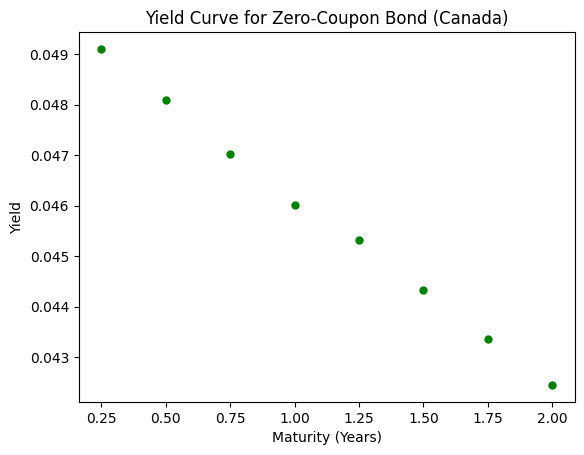

In [2]:
time = np.array((0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2))
canadian_rates = np.array((0.0491005, 0.0480828, 0.0470293, 0.0460044, 0.045323, 0.0443319, 0.043366, 0.0424488))

plt.plot(time, canadian_rates, "g.", markersize = 10)
plt.title('Yield Curve for Zero-Coupon Bond (Canada)')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')

Now we can convert the Zero-Coupon yield curve into Zero-Forward rates. Then since the data is relativley sparse, we can use a cubic spline to interpolate forward rates for the whole 2 year period, so that we have a smooth curve.

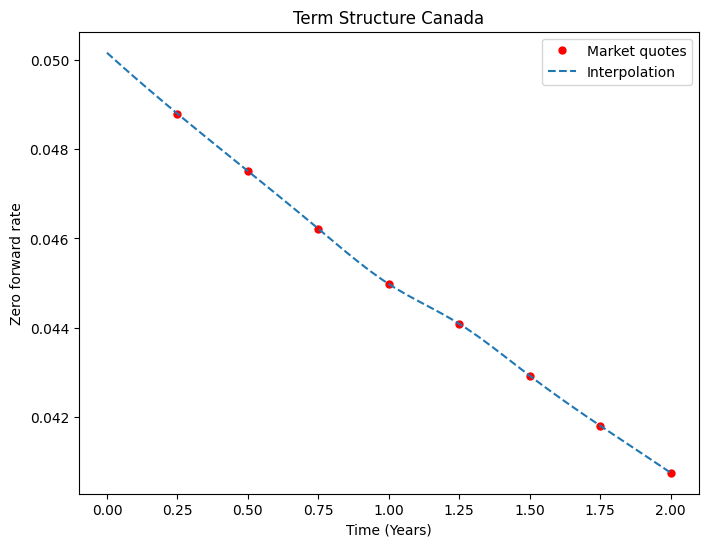

In [12]:
factors = 1 + time * canadian_rates
zero_forward_rates = 1 / time * np.log(factors)
cubic_spline = splrep(time, zero_forward_rates, k=3)  # Cubic spline
maturities = np.linspace(0.0, 2.0, 48)
inter_rates = splev(maturities, cubic_spline, der=0)  # Interpolated rates
first_der = splev(maturities, cubic_spline, der=1)  # First derivative
fwd = (inter_rates + first_der * maturities)  # Forward rate

plt.figure(figsize=(8, 6))
plt.plot(time, zero_forward_rates, "r.", markersize="10", label="Market quotes")
plt.plot(maturities, inter_rates, "--", markersize="10", label="Interpolation")
plt.xlabel("Time (Years)")
plt.ylabel("Zero forward rate")
plt.title("Term Structure Canada")
plt.legend()
plt.show()

Using these interpolated forward rates, and the forward rate structure defined by the CIR model, we can minimize the differences to get estimates for kappa, theta and sigma.

In [28]:
def CIR_fwd(params):
    #Forward rates in the CIR model
    k, th, sig = params
    t = maturities
    g = np.sqrt(k**2 + 2 * sig**2)
    s1 = (k * th * (np.exp(g * t) - 1)) / (2 * g + (k + g) * (np.exp(g * t) - 1))
    s2 = r0 * ((4 * g**2 * np.exp(g * t)) / (2 * g + (k + g) * (np.exp(g * t)) ** 2))
    return s1 + s2

def CIR_err(params):
    #MSE between market forward rates and CIR forward rates
    k, th, sig = params
    forward_rates = CIR_fwd(params)
    MSE = np.sum((fwd - forward_rates) ** 2) / len(fwd)
    return MSE

#Set an initial rate of 0.05 and minimize the differences in forward rates
r0 = canadian_rates[0]
parameters = fmin(CIR_err, [0.5, 0.2, 0.01],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=1000,
        maxfun=1000)
parameters

Optimization terminated successfully.
         Current function value: 0.000004
         Iterations: 71
         Function evaluations: 134


array([0.89443403, 0.03835686, 0.00991469])

After minimization using MSE for the differences, we get the following etimates for our three CIR parameters:
*   $\theta$ = 0.03835686
*   $k$ = 0.89443403
*   $\sigma$ = 0.00991469

Now using these parameters, we can simulate Monte Carlo CIR paths again for a period of 1 year and an initial interest rate of 5.01%, which is what CORRA is quoted to be on 2024-05-01.

Text(0, 0.5, 'r')

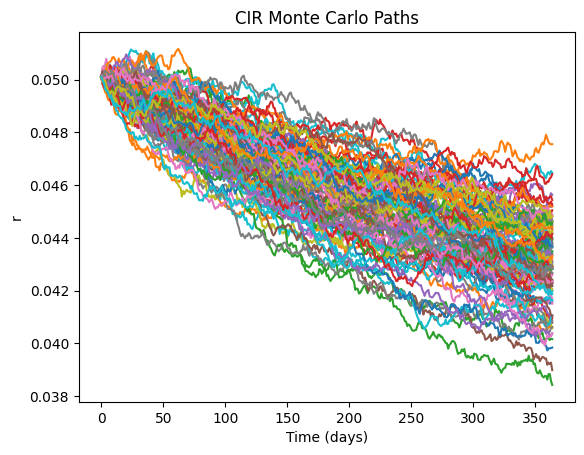

In [37]:
M = 100  # Number of path simulations
T = 1  # Ending of modelling time at 1 year
steps = 365  # 365 steps for 365 days in the year

r0 = 0.0501
k = 0.89443403
theta = 0.03835686
sigma = 0.00991469

df_cir_cad = pd.DataFrame()
for i in range(M):
  df_cir_cad[[i]] = cir(r0, k, theta, sigma, T, steps).tolist()

df_cir_cad.plot(legend=False)
plt.title('CIR Monte Carlo Paths')
plt.xlabel('Time (days)')
plt.ylabel('r')

In [38]:
print('The mean interest rate at the end of one year using CIR simulations is ' + str(np.mean(df_cir_cad.iloc[[-1]])) + '. With a standard deviation ' + str(df_cir_cad.std(axis=1).iloc[-1]) + '.')

The mean interest rate at the end of one year using CIR simulations is 0.04308549513591548. With a standard deviation 0.0016259573198049047.


Hence we have an estimate of the Canadian Interest Rate being 4.31% in 1 years time on 2025-05-01, with the standard deviation of our Monte Carlo paths being 0.0016.

Is this accurate? Who knows!

The CIR model is a single factor model, meaning that it only considers one predictor (short term interest rates) to explain interest rate movements. In reality, there is a much larger range of economic factors affecting interest rates and rate cuts which the model does not take into consideration. Because of this, we can't consider this prediction to be completely accurate - but it will be interesting to see in a year how close it was.